In [1]:
suppressMessages(suppressWarnings(source("../config/config_sing.R")))
show_env()

You are in Singularity: singularity_proj_combeffect 
BASE DIRECTORY:     /mount/work 
PATH OF SOURCE:     /mount/work/source 
PATH OF EXECUTABLE: /mount/work/exe 
PATH OF ANNOTATION: /mount/work/annotation 
PATH OF PROJECT:    /mount/project 
PATH OF RESULTS:    /mount/work/out/proj_combeffect_encode_fcc 


## Helper functions

In [2]:
PREFIX  = "KS91_K562_ASTARRseq"

REGIONS = c("GATA1", "MYC", "FADS")

GROUPS  = c("Input", "Output")

SAMPLES = c(
    paste0("Input_rep",  1:6),
    paste0("Output_rep", 1:4))

CNAMES = c("Chrom", "Start", "End", "Count")

get_info = function(fpath, strings){
    idx = str_detect(string = fpath, pattern = strings)
    return(strings[idx])
}

get_region = function(fpath){return(get_info(fpath, REGIONS))}
get_group  = function(fpath){return(get_info(fpath, GROUPS))}
get_sample = function(fpath){return(get_info(fpath, SAMPLES))}

## Library size

In [3]:
fdiry = file.path(FD_RES, "KS91_K562_ASTARRseq", "coverage", "library_size")
fname = "library_size_summary.csv"
fpath = file.path(fdiry, fname)

dat_lib = read_csv(fpath) %>% 
    dplyr::mutate(Size = Count) %>% 
    dplyr::select(Sample, Group, Size)
dat_lib

Rows: 10 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr (3): Fpath, Sample, Group
dbl (1): Count

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Sample,Group,Size
<chr>,<chr>,<dbl>
Input_rep1,Input,348695063
Input_rep2,Input,451369741
Input_rep3,Input,487579055
Input_rep4,Input,456246254
Input_rep5,Input,444268950
Input_rep6,Input,397333562
Output_rep1,Output,44103844
Output_rep2,Output,97471282
Output_rep3,Output,84103298


## Fragment counts

In [4]:
fdiry = file.path(FD_RES, PREFIX, "coverage_astarrseq_peak_macs_input")
fname = paste0("*bed*")
#dir(fdiry)
fglob = file.path(fdiry, fname)
fpaths = Sys.glob(fglob)
print(fpaths)

 [1] "/mount/work/out/proj_combeffect_encode_fcc/KS91_K562_ASTARRseq/coverage_astarrseq_peak_macs_input/KS91_K562_hg38_ASTARRseq_Input_rep1.FADS.unstranded.bed.gz"  
 [2] "/mount/work/out/proj_combeffect_encode_fcc/KS91_K562_ASTARRseq/coverage_astarrseq_peak_macs_input/KS91_K562_hg38_ASTARRseq_Input_rep1.GATA1.unstranded.bed.gz" 
 [3] "/mount/work/out/proj_combeffect_encode_fcc/KS91_K562_ASTARRseq/coverage_astarrseq_peak_macs_input/KS91_K562_hg38_ASTARRseq_Input_rep1.MYC.unstranded.bed.gz"   
 [4] "/mount/work/out/proj_combeffect_encode_fcc/KS91_K562_ASTARRseq/coverage_astarrseq_peak_macs_input/KS91_K562_hg38_ASTARRseq_Input_rep2.FADS.unstranded.bed.gz"  
 [5] "/mount/work/out/proj_combeffect_encode_fcc/KS91_K562_ASTARRseq/coverage_astarrseq_peak_macs_input/KS91_K562_hg38_ASTARRseq_Input_rep2.GATA1.unstranded.bed.gz" 
 [6] "/mount/work/out/proj_combeffect_encode_fcc/KS91_K562_ASTARRseq/coverage_astarrseq_peak_macs_input/KS91_K562_hg38_ASTARRseq_Input_rep2.MYC.unstranded.bed.gz"   
 [7]

In [5]:
lst = lapply(fpaths, function(fpath){
    ###
    reg = get_region(fpath)
    grp = get_group(fpath)
    sam = get_sample(fpath)
    #print(fpath)
    #cat("Region:", reg, ";", "Group:", grp, ";", "Sample:", sam, "\n")
    #flush.console()
    
    ###
    dat = read_tsv(fpath, col_name = CNAMES, show_col_types = FALSE)
    dat = dat %>% 
        dplyr::mutate(Region = reg, Group = grp, Sample = sam) %>%
        dplyr::mutate(across(Count, na_if, ".")) %>%
        dplyr::mutate(across(Count, as.integer)) %>%
        na.omit
    return(dat)
})

dat_cnt = bind_rows(lst)
print(dim(dat_cnt))
head(dat_cnt)

[1] 4049    7


Chrom,Start,End,Count,Region,Group,Sample
<chr>,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>
chr11,61792068,61793464,4507,FADS,Input,Input_rep1
chr11,61800085,61801113,1485,FADS,Input,Input_rep1
chr11,61806630,61807154,144,FADS,Input,Input_rep1
chr11,61814735,61817343,10734,FADS,Input,Input_rep1
chr11,61822094,61822443,64,FADS,Input,Input_rep1
chr11,61825795,61826306,79,FADS,Input,Input_rep1


In [6]:
### summarize
dat_stats = left_join(dat_cnt, dat_lib, by=c("Sample", "Group")) %>% 
    mutate(Cpm = Count * 10^6 / Size)  %>%
    group_by(Chrom, Start, End, Group, Region) %>%
    summarise(Cpm = mean(Cpm, na.rm=TRUE), .groups = 'drop')

In [7]:
dat_stats

Chrom,Start,End,Group,Region,Cpm
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
chr11,61792068,61793464,Input,FADS,12.5686237
chr11,61792068,61793464,Output,FADS,133.2149474
chr11,61800085,61801113,Input,FADS,4.0988290
chr11,61800085,61801113,Output,FADS,132.4037695
chr11,61806630,61807154,Input,FADS,0.4372774
chr11,61806630,61807154,Output,FADS,1.7996840
chr11,61814735,61817343,Input,FADS,29.6676205
chr11,61814735,61817343,Output,FADS,193.2290767
chr11,61822094,61822443,Input,FADS,0.1664847


Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


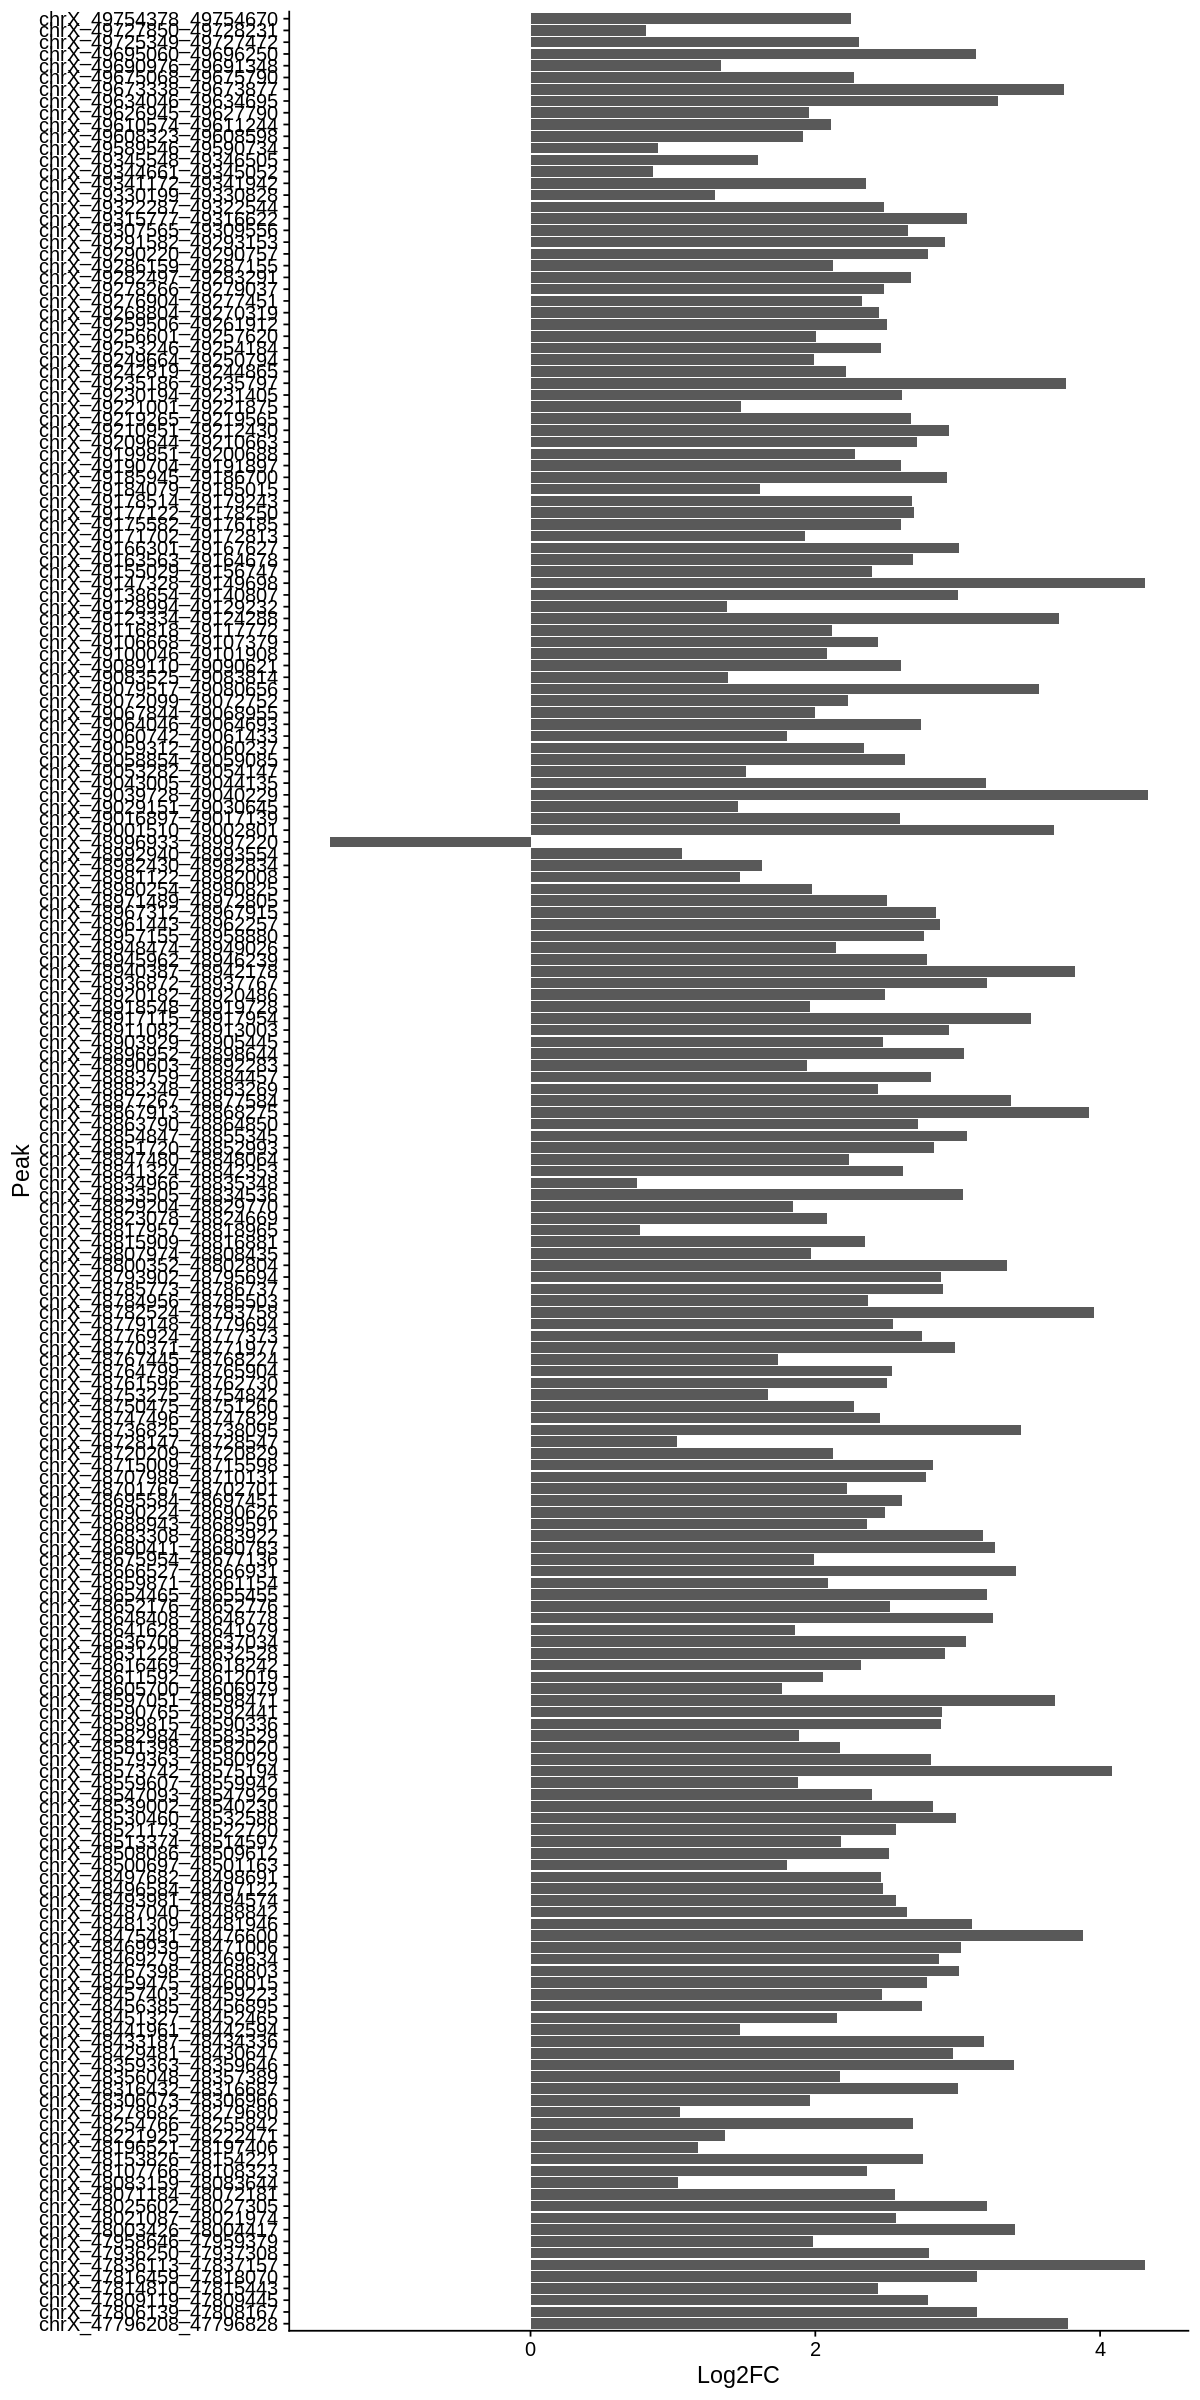

In [8]:
dat = dat_stats
dat = dat %>% 
    dplyr::filter(Region == "GATA1") %>% 
    spread(Group, Cpm) %>% 
    mutate(Log2FC = log2(Output / Input)) %>%
    mutate(Peak=paste(Chrom, Start, End, sep="_"))

gpt = ggplot(dat, aes(x=Log2FC, y=Peak)) + 
    geom_histogram(stat="identity") + 
    theme_cowplot()

options(repr.plot.height=20, repr.plot.width=10)
print(gpt)

Warning message:
“Ignoring unknown parameters: binwidth, bins, pad”


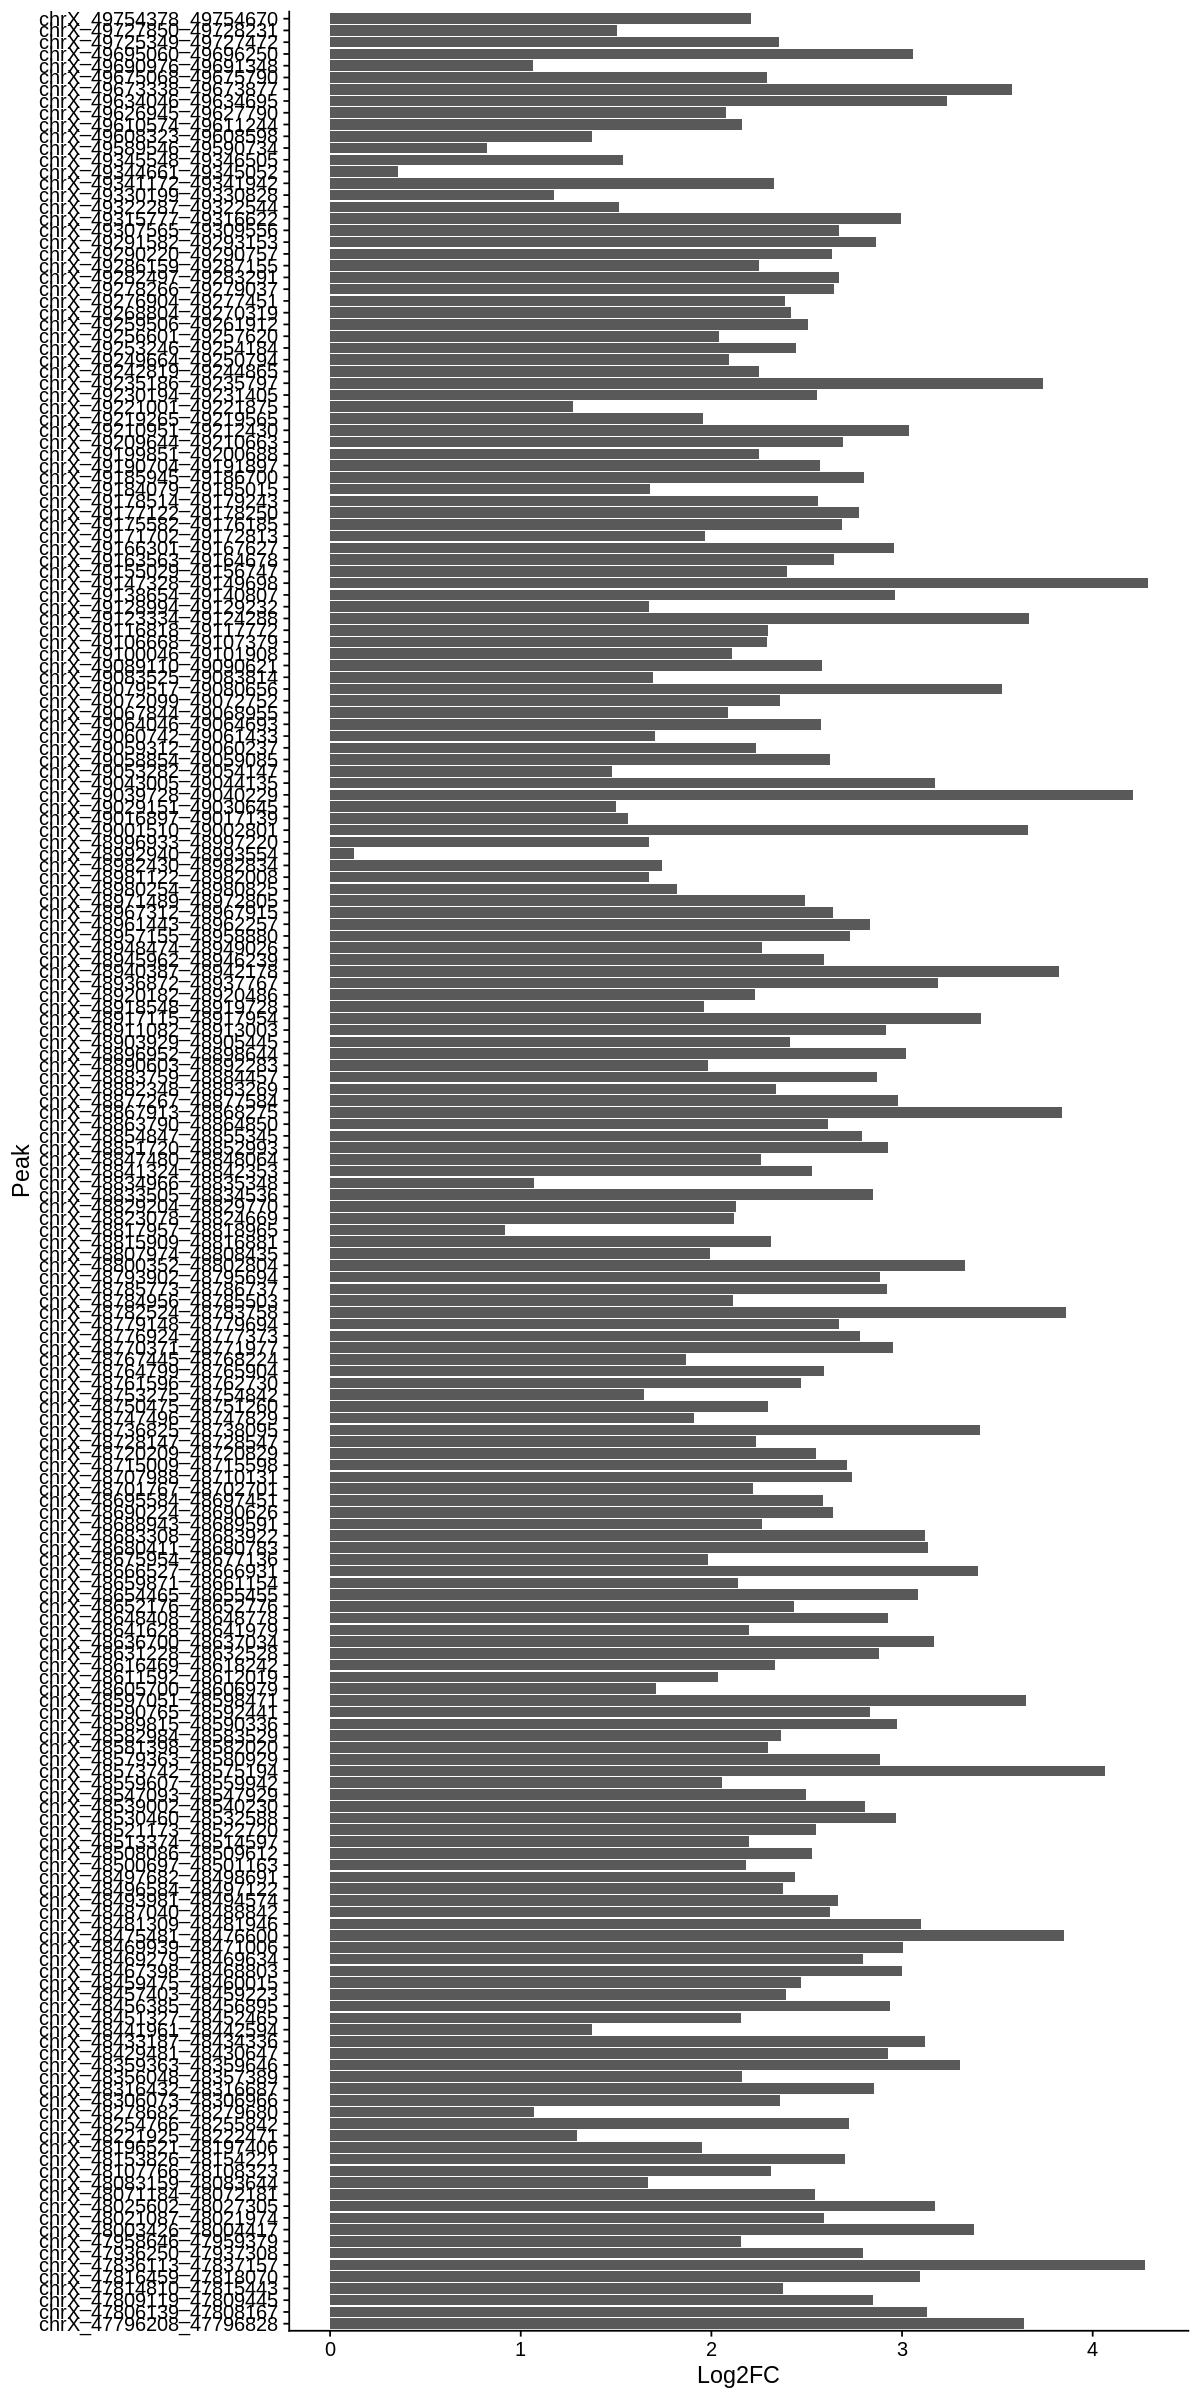

In [11]:
dat = dat_stats
dat = dat %>% 
    dplyr::filter(Region == "GATA1") %>% 
    spread(Group, Cpm) %>% 
    mutate(Log2FC = log2(Output / Input)) %>%
    mutate(Peak=paste(Chrom, Start, End, sep="_"))

gpt = ggplot(dat, aes(x=Log2FC, y=Peak)) + 
    geom_histogram(stat="identity") + 
    theme_cowplot()

options(repr.plot.height=20, repr.plot.width=10)
print(gpt)

In [ ]:
dat_cov_astarr = dat_peak_cov_astarr %>% dplyr::filter(Peak %in% peaks) %>% spread(Group, Cpm) %>% mutate(Log2FC = log2(Output / Input))

In [9]:
PREFIX

[1] "KS91_K562_ASTARRseq"

In [10]:
fdiry = file.path(FD_RES, PREFIX, "coverage_astarrseq_peak_macs_input", "summary")
fname = paste0(PREFIX, "_summary.unstranded.tsv")
fpath = file.path(fdiry, fname)
write_tsv(dat_stats, fpath)